---
# Setup

Install required Packages & environment variables

In [ ]:
%%capture --no-stderr
%pip install --upgrade --quiet langchain-community langgraph

##### LLM

In [ ]:
!pip install -qU "langchain[google-genai]"
from google.colab import userdata

# Retrieve the Gemini API key from Colab's user data
gemini_api_key = userdata.get('gemini')

from langchain.chat_models import init_chat_model

llm = init_chat_model("gemini-2.0-flash", model_provider="google_genai",google_api_key=gemini_api_key)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.4/47.4 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 22.4 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-generativeai 0.8.5 requires google-ai-generativelanguage==0.6.15, but you have google-ai-generativelanguage 0.6.18 which is incompatible.


##### Smith

In [ ]:
#Smith
from google.colab import userdata
import os
os.environ["LANGSMITH_TRACING_V2"] = "true"
os.environ["LANGSMITH_API_KEY"] = userdata.get('Smith2')

---
# Sample Data


SQLlite DB with ChinookDB

### 1. from Sample data folder

In [ ]:
from langchain_community.utilities import SQLDatabase

db = SQLDatabase.from_uri("sqlite:////content/sample_data/Chinook.db")
print(db.dialect)
print(db.get_usable_table_names())
db.run("SELECT * FROM Genre LIMIT 10;")

sqlite
[]


OperationalError: (sqlite3.OperationalError) no such table: Genre
[SQL: SELECT * FROM Genre LIMIT 10;]
(Background on this error at: https://sqlalche.me/e/20/e3q8)

### 2. from G Drive Mounting


In [ ]:
from langchain_community.utilities import SQLDatabase

db = SQLDatabase.from_uri("sqlite:////content/drive/MyDrive/Chinook.db")
print(db.dialect)
print(db.get_usable_table_names())
db.run("SELECT * FROM Genre LIMIT 10;")

sqlite
['Album', 'Artist', 'Customer', 'Employee', 'Genre', 'Invoice', 'InvoiceLine', 'MediaType', 'Playlist', 'PlaylistTrack', 'Track']


"[(1, 'Rock'), (2, 'Jazz'), (3, 'Metal'), (4, 'Alternative & Punk'), (5, 'Rock And Roll'), (6, 'Blues'), (7, 'Latin'), (8, 'Reggae'), (9, 'Pop'), (10, 'Soundtrack')]"

### 3. Upload from Local during every Runtime

In [ ]:
from langchain_community.utilities import SQLDatabase

db = SQLDatabase.from_uri("sqlite:///Chinook.db")
print(db.dialect)
print(db.get_usable_table_names())
db.run("SELECT * FROM Genre LIMIT 10;")

sqlite
['Album', 'Artist', 'Customer', 'Employee', 'Genre', 'Invoice', 'InvoiceLine', 'MediaType', 'Playlist', 'PlaylistTrack', 'Track']


"[(1, 'Rock'), (2, 'Jazz'), (3, 'Metal'), (4, 'Alternative & Punk'), (5, 'Rock And Roll'), (6, 'Blues'), (7, 'Latin'), (8, 'Reggae'), (9, 'Pop'), (10, 'Soundtrack')]"

---
# Chains


### Application State

In [ ]:
from typing_extensions import TypedDict


class State(TypedDict):
    question: str
    query: str
    result: str
    answer: str

### Convert Question to SQL query

##### Instructions for LLM
> (System Message (+ `Parameters`), question)





In [ ]:
from langchain_core.prompts import ChatPromptTemplate

system_message = """
Given an input question, create a syntactically correct {dialect} query to
run to help find the answer. Unless the user specifies in his question a
specific number of examples they wish to obtain, always limit your query to
at most {top_k} results. You can order the results by a relevant column to
return the most interesting examples in the database.

Never query for all the columns from a specific table, only ask for a the
few relevant columns given the question.

Pay attention to use only the column names that you can see in the schema
description. Be careful to not query for columns that do not exist. Also,
pay attention to which column is in which table.

Only use the following tables:
{table_info}
"""

user_prompt = "Question: {input}"

query_prompt_template = ChatPromptTemplate(
    [("system", system_message), ("user", user_prompt)]
)

for message in query_prompt_template.messages:
    message.pretty_print()

================================ System Message ================================


Given an input question, create a syntactically correct {dialect} query to
run to help find the answer. Unless the user specifies in his question a
specific number of examples they wish to obtain, always limit your query to
at most {top_k} results. You can order the results by a relevant column to
return the most interesting examples in the database.

Never query for all the columns from a specific table, only ask for a the
few relevant columns given the question.

Pay attention to use only the column names that you can see in the schema
description. Be careful to not query for columns that do not exist. Also,
pay attention to which column is in which table.

Only use the following tables:
{table_info}

================================ Human Message =================================

Question: {input}


##### WriteQuery Method
> to populate parameters

In [ ]:
from typing_extensions import Annotated


class QueryOutput(TypedDict):
    """Generated SQL query."""

    query: Annotated[str, ..., "Syntactically valid SQL query."]


def write_query(state: State):
    """Generate SQL query to fetch information."""
    prompt = query_prompt_template.invoke(
        {
            "dialect": db.dialect,
            "top_k": 10,
            "table_info": db.get_table_info(),
            "input": state["question"],
        }
    )
    structured_llm = llm.with_structured_output(QueryOutput)
    result = structured_llm.invoke(prompt)
    return {"query": result["query"]}

In [ ]:
write_query({"question": "What all headers are there?"})
#write_query({"question": "How many Employees are there?"})

{'query': "SELECT sql FROM sqlite_master WHERE type='table'"}

### Execute Query
> Exe Q node tool

In [ ]:
from langchain_community.tools.sql_database.tool import QuerySQLDatabaseTool


def execute_query(state: State):
    """Execute SQL query."""
    execute_query_tool = QuerySQLDatabaseTool(db=db)
    return {"result": execute_query_tool.invoke(state["query"])}

In [ ]:
execute_query({"query": "SELECT sql FROM sqlite_master WHERE type='table'"})

{'result': "[('CREATE TABLE [Album]\\n(\\n    [AlbumId] INTEGER  NOT NULL,\\n    [Title] NVARCHAR(160)  NOT NULL,\\n    [ArtistId] INTEGER  NOT NULL,\\n    CONSTRAINT [PK_Album] PRIMARY KEY  ([AlbumId]),\\n    FOREIGN KEY ([ArtistId]) REFERENCES [Artist] ([ArtistId]) \\n\\t\\tON DELETE NO ACTION ON UPDATE NO ACTION\\n)',), ('CREATE TABLE [Artist]\\n(\\n    [ArtistId] INTEGER  NOT NULL,\\n    [Name] NVARCHAR(120),\\n    CONSTRAINT [PK_Artist] PRIMARY KEY  ([ArtistId])\\n)',), ('CREATE TABLE [Customer]\\n(\\n    [CustomerId] INTEGER  NOT NULL,\\n    [FirstName] NVARCHAR(40)  NOT NULL,\\n    [LastName] NVARCHAR(20)  NOT NULL,\\n    [Company] NVARCHAR(80),\\n    [Address] NVARCHAR(70),\\n    [City] NVARCHAR(40),\\n    [State] NVARCHAR(40),\\n    [Country] NVARCHAR(40),\\n    [PostalCode]...',), ('CREATE TABLE [Employee]\\n(\\n    [EmployeeId] INTEGER  NOT NULL,\\n    [LastName] NVARCHAR(20)  NOT NULL,\\n    [FirstName] NVARCHAR(20)  NOT NULL,\\n    [Title] NVARCHAR(30),\\n    [ReportsTo] I

### Generate Answer

In [ ]:
def generate_answer(state: State):
    """Answer question using retrieved information as context."""
    prompt = (
        "Given the following user question, corresponding SQL query, "
        "and SQL result, answer the user question.\n\n"
        f'Question: {state["question"]}\n'
        f'SQL Query: {state["query"]}\n'
        f'SQL Result: {state["result"]}'
    )
    response = llm.invoke(prompt)
    return {"answer": response.content}

### Orchestrating with LangGraph

In [ ]:
from langgraph.graph import START, StateGraph

graph_builder = StateGraph(State).add_sequence(
    [write_query, execute_query, generate_answer]
)
graph_builder.add_edge(START, "write_query")
graph = graph_builder.compile()

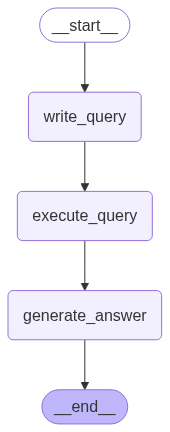

In [ ]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

#### Test the *App*

In [ ]:
for step in graph.stream(
    {"question": "How many headers are there in the database? What are they"}, stream_mode="updates"
):
    print(step)

#for step in graph.stream(
#    {"question": "How many employees are there?"}, stream_mode="updates"
#):
#    print(step)

{'write_query': {'query': "SELECT sql FROM sqlite_master WHERE type='table';"}}
{'execute_query': {'result': "[('CREATE TABLE [Album]\\n(\\n    [AlbumId] INTEGER  NOT NULL,\\n    [Title] NVARCHAR(160)  NOT NULL,\\n    [ArtistId] INTEGER  NOT NULL,\\n    CONSTRAINT [PK_Album] PRIMARY KEY  ([AlbumId]),\\n    FOREIGN KEY ([ArtistId]) REFERENCES [Artist] ([ArtistId]) \\n\\t\\tON DELETE NO ACTION ON UPDATE NO ACTION\\n)',), ('CREATE TABLE [Artist]\\n(\\n    [ArtistId] INTEGER  NOT NULL,\\n    [Name] NVARCHAR(120),\\n    CONSTRAINT [PK_Artist] PRIMARY KEY  ([ArtistId])\\n)',), ('CREATE TABLE [Customer]\\n(\\n    [CustomerId] INTEGER  NOT NULL,\\n    [FirstName] NVARCHAR(40)  NOT NULL,\\n    [LastName] NVARCHAR(20)  NOT NULL,\\n    [Company] NVARCHAR(80),\\n    [Address] NVARCHAR(70),\\n    [City] NVARCHAR(40),\\n    [State] NVARCHAR(40),\\n    [Country] NVARCHAR(40),\\n    [PostalCode]...',), ('CREATE TABLE [Employee]\\n(\\n    [EmployeeId] INTEGER  NOT NULL,\\n    [LastName] NVARCHAR(20)  N

### Human in the Loop

In [ ]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()
graph = graph_builder.compile(checkpointer=memory, interrupt_before=["execute_query"])

# Now that we're using persistence, we need to specify a thread ID
# so that we can continue the run after review.
config = {"configurable": {"thread_id": "1"}}

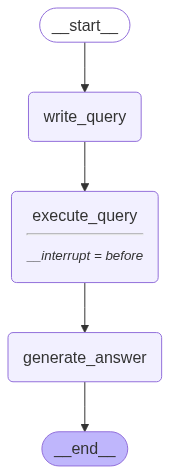

In [ ]:
display(Image(graph.get_graph().draw_mermaid_png()))

Lets run the steps

In [ ]:
for step in graph.stream(
    {"question": "How many employees are there?"},
    config,
    stream_mode="updates",
):
    print(step)

try:
    user_approval = input("Do you want to go to execute query? (yes/no): ")
except Exception:
    user_approval = "no"

if user_approval.lower() == "yes":
    # If approved, continue the graph execution
    for step in graph.stream(None, config, stream_mode="updates"):
        print(step)
else:
    print("Operation cancelled by user.")

{'write_query': {'query': 'SELECT count(*) FROM Employee'}}
{'__interrupt__': ()}
Do you want to go to execute query? (yes/no): no
Operation cancelled by user.


---
# Agents

We will use - SQLDatabaseToolkit for toolcalls and ReAct agent constructor

In [ ]:
from langchain_community.agent_toolkits import SQLDatabaseToolkit

toolkit = SQLDatabaseToolkit(db=db, llm=llm)

tools = toolkit.get_tools()

tools

[QuerySQLDatabaseTool(description="Input to this tool is a detailed and correct SQL query, output is a result from the database. If the query is not correct, an error message will be returned. If an error is returned, rewrite the query, check the query, and try again. If you encounter an issue with Unknown column 'xxxx' in 'field list', use sql_db_schema to query the correct table fields.", db=<langchain_community.utilities.sql_database.SQLDatabase object at 0x7f7aac54f750>),
 InfoSQLDatabaseTool(description='Input to this tool is a comma-separated list of tables, output is the schema and sample rows for those tables. Be sure that the tables actually exist by calling sql_db_list_tables first! Example Input: table1, table2, table3', db=<langchain_community.utilities.sql_database.SQLDatabase object at 0x7f7aac54f750>),
 ListSQLDatabaseTool(db=<langchain_community.utilities.sql_database.SQLDatabase object at 0x7f7aac54f750>),
 QuerySQLCheckerTool(description='Use this tool to double check

### System Prompt

In [ ]:
system_message = """
You are an agent designed to interact with a SQL database.
Given an input question, create a syntactically correct {dialect} query to run,
then look at the results of the query and return the answer. Unless the user
specifies a specific number of examples they wish to obtain, always limit your
query to at most {top_k} results.

You can order the results by a relevant column to return the most interesting
examples in the database. Never query for all the columns from a specific table,
only ask for the relevant columns given the question.

You MUST double check your query before executing it. If you get an error while
executing a query, rewrite the query and try again.

DO NOT make any DML statements (INSERT, UPDATE, DELETE, DROP etc.) to the
database.

To start you should ALWAYS look at the tables in the database to see what you
can query. Do NOT skip this step.

Then you should query the schema of the most relevant tables.
""".format(
    dialect="SQLite",
    top_k=5,
)

### Initializing Agent

In [ ]:
from langchain_core.messages import HumanMessage
from langgraph.prebuilt import create_react_agent

agent_executor = create_react_agent(llm, tools, prompt=system_message)

Test ; consider

In [ ]:
question = "Which country's customers spent the most?"

for step in agent_executor.stream(
    {"messages": [{"role": "user", "content": question}]},
    stream_mode="values",
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

Which country's customers spent the most?
================================== Ai Message ==================================

I need to find the total spending of customers from each country. To do this, I need to find the tables that contain customer information and order information. I will start by listing the tables in the database.
Tool Calls:
  sql_db_list_tables (065bb83a-e671-4898-b7dd-8f38f1cb14b2)
 Call ID: 065bb83a-e671-4898-b7dd-8f38f1cb14b2
  Args:
================================= Tool Message =================================
Name: sql_db_list_tables

Album, Artist, Customer, Employee, Genre, Invoice, InvoiceLine, MediaType, Playlist, PlaylistTrack, Track
================================== Ai Message ==================================

I should explore the Customer and Invoice tables to determine which country's customers spent the most. First, I need to see the schema of these tables.
Tool C

Qualitative Question

In [ ]:
question = "Describe the playlisttrack table"

for step in agent_executor.stream(
    {"messages": [{"role": "user", "content": question}]},
    stream_mode="values",
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

Describe the playlisttrack table
================================== Ai Message ==================================
Tool Calls:
  sql_db_schema (526fdb1d-c1d8-47c5-830a-8b082611a200)
 Call ID: 526fdb1d-c1d8-47c5-830a-8b082611a200
  Args:
    table_names: playlisttrack
================================= Tool Message =================================
Name: sql_db_schema

Error: table_names {'playlisttrack'} not found in database
================================== Ai Message ==================================

That's strange, I should have been able to find the table. Let me first list all the tables in the database.
Tool Calls:
  sql_db_list_tables (9fdd6b2f-1d4e-4e5d-b52c-450691cf1550)
 Call ID: 9fdd6b2f-1d4e-4e5d-b52c-450691cf1550
  Args:
================================= Tool Message =================================
Name: sql_db_list_tables

Album, Artist, Customer, Employee, Genre, Invoice, InvoiceLine, M

### Dealing with high-cardinality columns

First we need the unique values for each entity we want, for which we define a function that parses the result into a list of elements:

In [ ]:
import ast
import re


def query_as_list(db, query):
    res = db.run(query)
    res = [el for sub in ast.literal_eval(res) for el in sub if el]
    res = [re.sub(r"\b\d+\b", "", string).strip() for string in res]
    return list(set(res))


artists = query_as_list(db, "SELECT Name FROM Artist")
albums = query_as_list(db, "SELECT Title FROM Album")
albums[:5]

['Beethoven Piano Sonatas: Moonlight & Pastorale',
 'Quanta Gente Veio Ver (Live)',
 'Santana - As Years Go By',
 'The Last Night of the Proms',
 'Acústico MTV [Live]']

Using this function, we can create a retriever tool that the agent can execute at its discretion.

In [ ]:
#Embedding Model

!pip install -qU "langchain[google-genai]"
from google.colab import userdata

# Retrieve the Gemini API key from Colab's user data
gemini_api_key = userdata.get('gemini')

from langchain_google_genai import GoogleGenerativeAIEmbeddings

embeddings = GoogleGenerativeAIEmbeddings(model="models/embedding-001", google_api_key=gemini_api_key)

In [ ]:
# Vector Store

!pip install -qU langchain-core

In [ ]:
from langchain_core.vectorstores import InMemoryVectorStore

vector_store = InMemoryVectorStore(embeddings)

construct a retrieval tool that can search over relevant proper nouns in the database:

In [ ]:
from langchain.agents.agent_toolkits import create_retriever_tool

_ = vector_store.add_texts(artists + albums)
retriever = vector_store.as_retriever(search_kwargs={"k": 5})
description = (
    "Use to look up values to filter on. Input is an approximate spelling "
    "of the proper noun, output is valid proper nouns. Use the noun most "
    "similar to the search."
)
retriever_tool = create_retriever_tool(
    retriever,
    name="search_proper_nouns",
    description=description,
)

Lets try out

In [ ]:
print(retriever_tool.invoke("Alice Chains"))

Alice In Chains

Audioslave

Audioslave

Amy Winehouse

Metallica


Putting it together into the agent

In [ ]:
# Add to system message
suffix = (
    "If you need to filter on a proper noun like a Name, you must ALWAYS first look up "
    "the filter value using the 'search_proper_nouns' tool! Do not try to "
    "guess at the proper name - use this function to find similar ones."
)

system = f"{system_message}\n\n{suffix}"

tools.append(retriever_tool)

agent = create_react_agent(llm, tools, prompt=system)

Lets run

In [ ]:
question = "How many trackks does skank have?"

for step in agent.stream(
    {"messages": [{"role": "user", "content": question}]},
    stream_mode="values",
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

How many trackks does skank have?
================================== Ai Message ==================================
Tool Calls:
  search_proper_nouns (c9c39e1d-1fe1-4920-ac60-73f6952676dd)
 Call ID: c9c39e1d-1fe1-4920-ac60-73f6952676dd
  Args:
    query: Skank
================================= Tool Message =================================
Name: search_proper_nouns

Skank

Kiss

The Police

Na Pista

Powerslave
================================== Ai Message ==================================
Tool Calls:
  sql_db_list_tables (fe3831eb-0d96-4d3f-aa91-2a2bdf56644f)
 Call ID: fe3831eb-0d96-4d3f-aa91-2a2bdf56644f
  Args:
================================= Tool Message =================================
Name: sql_db_list_tables

Album, Artist, Customer, Employee, Genre, Invoice, InvoiceLine, MediaType, Playlist, PlaylistTrack, Track
================================== Ai Message ==================================
To


---